In [72]:
# Preprocessing
import pandas as pd

# Load and transpose the team activity data
team_activity_file_path = 'data/team_activity.csv'
team_activity_df = pd.read_csv(team_activity_file_path, index_col=0).transpose()

# Define the mapping from qualitative descriptions to numerical values
involvement_mapping = {
    'Strong': 3,
    'Good': 2,
    'Average': 1,
    'None': 0
}

# Define involvement columns
involvement_columns = ['Funding', 'Application-Oriented', 'Demos', 'Industrial Collaborations', 'System Maturity', 'Number of Members', 'Academic Collaborations']

# Convert qualitative descriptions to numerical values
for column in involvement_columns:
    if column in team_activity_df.columns:
        team_activity_df[column] = team_activity_df[column].map(involvement_mapping).fillna(0)

# Define feature weights
feature_weights = {
    'Demos': 5,
    'Industrial Collaborations': 5,
    'Academic Collaborations': 3,
    'Application-Oriented': 3,
    'System Maturity': 2,
    'Funding': 1,
    'Number of Members': 1,
}

# Calculate performance scores based on the mapping and weights
def calculate_performance_score(row, weights):
    score = 0
    for feature, weight in weights.items():
        if feature in row:
            score += row[feature] * weight
    return score

team_activity_df['Performance Score'] = team_activity_df.apply(calculate_performance_score, axis=1, weights=feature_weights)

# Reset index to have 'Team' as a column
team_activity_df.reset_index(inplace=True)
team_activity_df.rename(columns={'index': 'Team'}, inplace=True)

# Display the updated DataFrame
print(team_activity_df.head())


Team    Team  Funding  Application-Oriented  Number of Members  \
0       DICE      1.0                   2.0                  1   
1     MagICL      3.0                   3.0                  3   
2     BioHIT      3.0                   3.0                  2   
3       CAKT      3.0                   3.0                  2   
4        CER      2.0                   2.0                  3   

Team  Academic Collaborations  System Maturity  Demos  \
0                         2.0              2.0    2.0   
1                         3.0              3.0    3.0   
2                         2.0              2.0    2.0   
3                         3.0              3.0    3.0   
4                         0.0              3.0    3.0   

Team  Industrial Collaborations  Performance Score  
0                           1.0               33.0  
1                           3.0               60.0  
2                           1.0               39.0  
3                           3.0               59

In [23]:
team_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Team                       14 non-null     object 
 1   Funding                    14 non-null     float64
 2   Application-Oriented       14 non-null     float64
 3   Number of Members          14 non-null     int64  
 4   Academic Collaborations    14 non-null     float64
 5   System Maturity            14 non-null     float64
 6   Demos                      14 non-null     float64
 7   Industrial Collaborations  14 non-null     float64
 8   Performance Score          14 non-null     float64
 9   Cluster                    14 non-null     int32  
 10  PCA1                       14 non-null     float64
 11  PCA2                       14 non-null     float64
dtypes: float64(9), int32(1), int64(1), object(1)
memory usage: 1.4+ KB


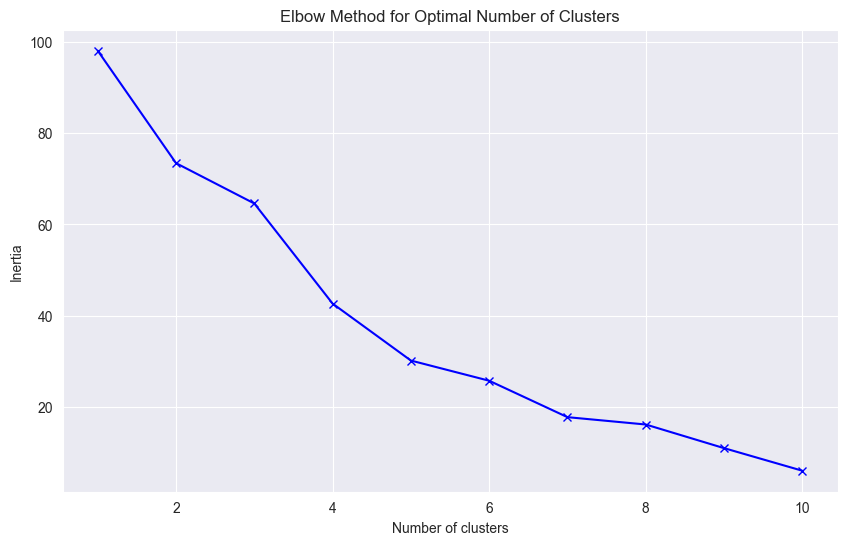

In [73]:
# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define features for clustering
features_c = [col for col in team_activity_df.columns if col not in ['Performance Score', 'Team']]
X = team_activity_df[features_c]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow method
def plot_elbow_method(X):
    inertia = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

plot_elbow_method(X_scaled)

# Apply clustering with an optimal number of clusters
num_clusters = 3  # Update this based on the Elbow method result
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
team_activity_df['Cluster'] = kmeans.fit_predict(X_scaled)


In [53]:

# Display the updated DataFrame with clusters
print(team_activity_df.head())

Team    Team  Funding  Application-Oriented  Number of Members  \
0       DICE      1.0                   2.0                  1   
1     MagICL      3.0                   3.0                  3   
2     BioHIT      3.0                   3.0                  2   
3       CAKT      3.0                   3.0                  2   
4        CER      2.0                   2.0                  3   

Team  Academic Collaborations  System Maturity  Demos  \
0                         2.0              2.0    2.0   
1                         3.0              3.0    3.0   
2                         2.0              2.0    2.0   
3                         3.0              3.0    3.0   
4                         0.0              3.0    3.0   

Team  Industrial Collaborations  Performance Score  Cluster  
0                           1.0               33.0        0  
1                           3.0               60.0        2  
2                           1.0               39.0        1  
3           

In [54]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# Visualize individual team performance
def plot_individual_performance(df):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Team', y='Performance Score', hue='Team', data=df, palette='viridis', dodge=False, legend=False)
    plt.title('Team Performance Scores')
    plt.xlabel('Team')
    plt.ylabel('Performance Score')
    plt.xticks(rotation=45)
    plt.show()

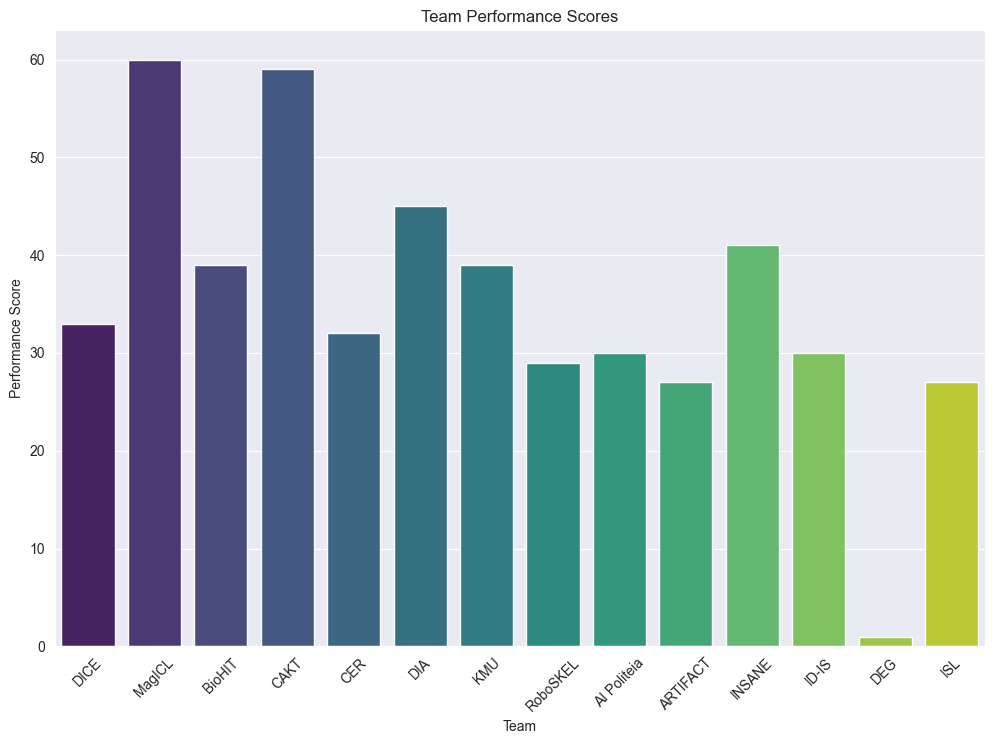

In [55]:
plot_individual_performance(team_activity_df)

In [56]:
# Visualize overall performance distribution
def plot_performance_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Performance Score'], kde=True, color='blue')
    plt.title('Performance Score Distribution')
    plt.xlabel('Performance Score')
    plt.ylabel('Frequency')
    plt.show()

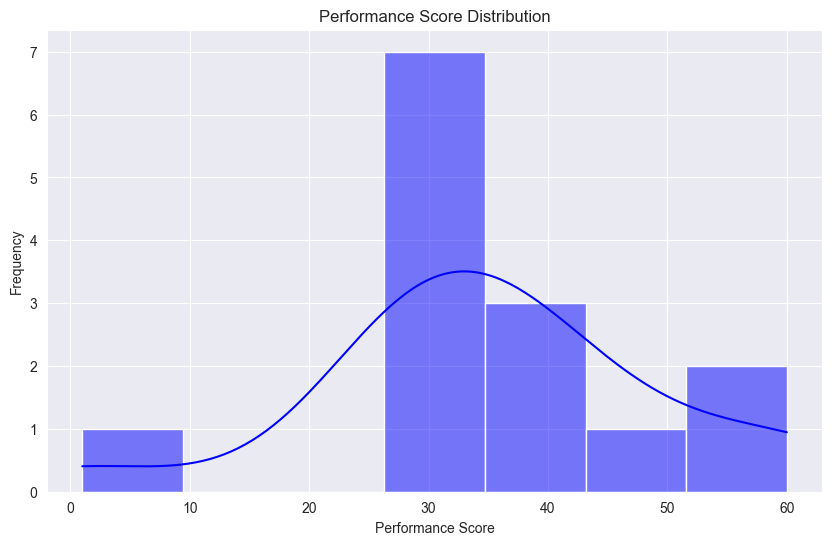

In [57]:
plot_performance_distribution(team_activity_df)

In [58]:
# Visualize cluster distribution
def plot_cluster_distribution(df):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Team', y='Performance Score', hue='Cluster', data=df, palette='viridis')
    plt.title('Cluster Distribution')
    plt.xlabel('Team')
    plt.ylabel('Performance Score')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.show()

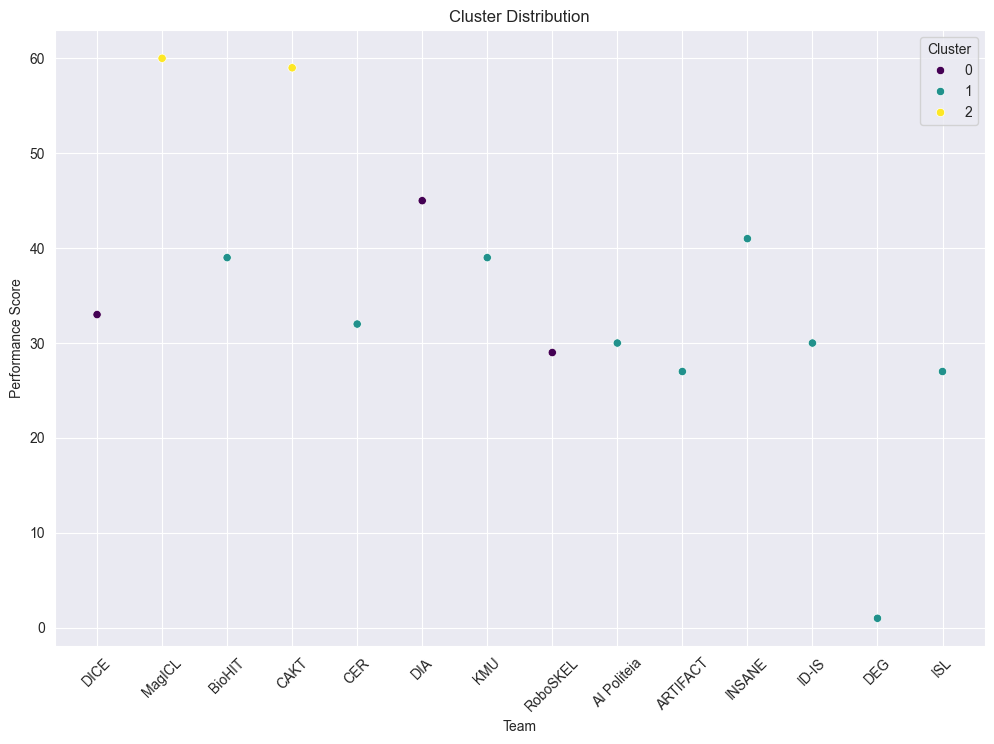

In [59]:
plot_cluster_distribution(team_activity_df)

In [ ]:
# PCA visualization
def plot_pca(df, features):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df[features])
    
    df['PCA1'] = pca_results[:, 0]
    df['PCA2'] = pca_results[:, 1]
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis')
    plt.title('PCA Visualization')
    plt.show()

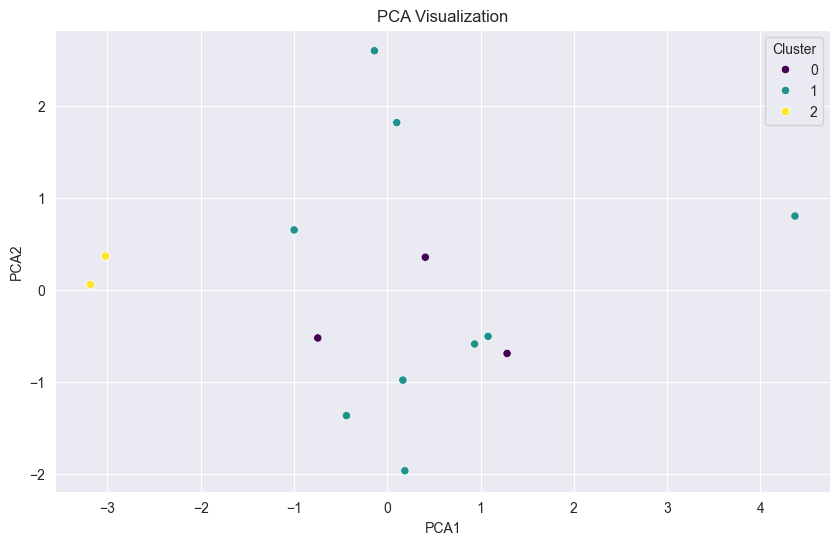

In [63]:
plot_pca(team_activity_df, features_c)

In [66]:
# Box plot for comparing feature distributions across clusters
def plot_cluster_box_plots(df, features):
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster', y=feature, data=df, legend = False, hue = 'Cluster')
        plt.title(f'{feature} Distribution by Cluster')
        plt.show()

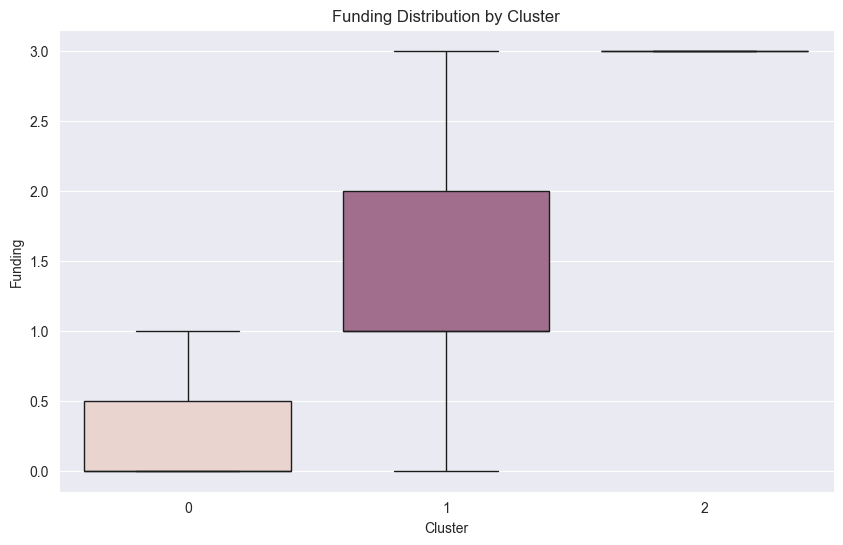

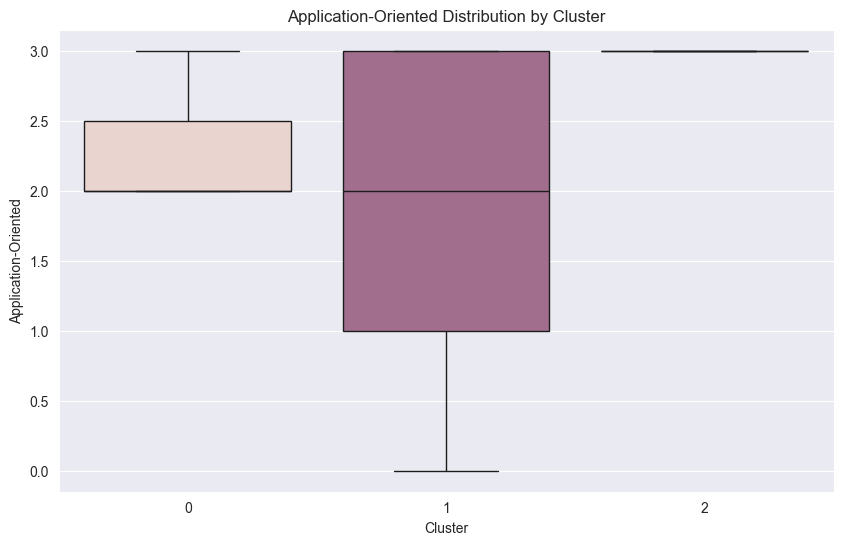

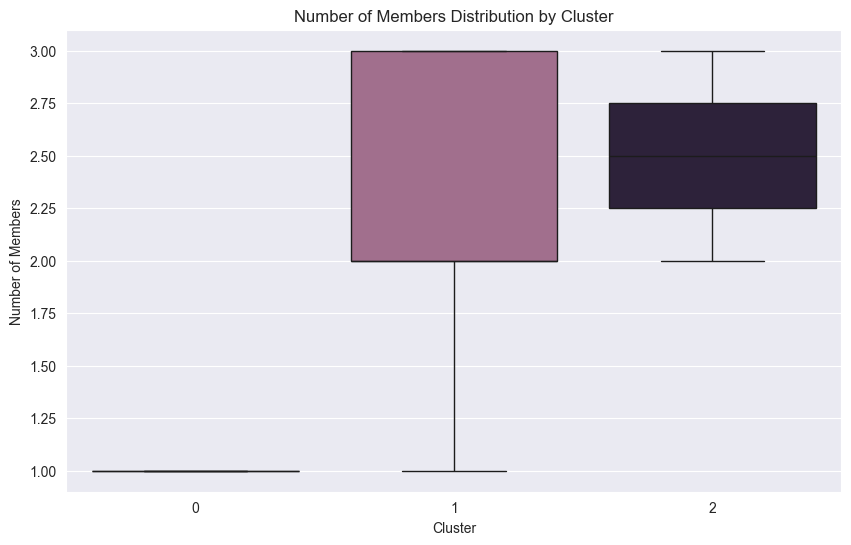

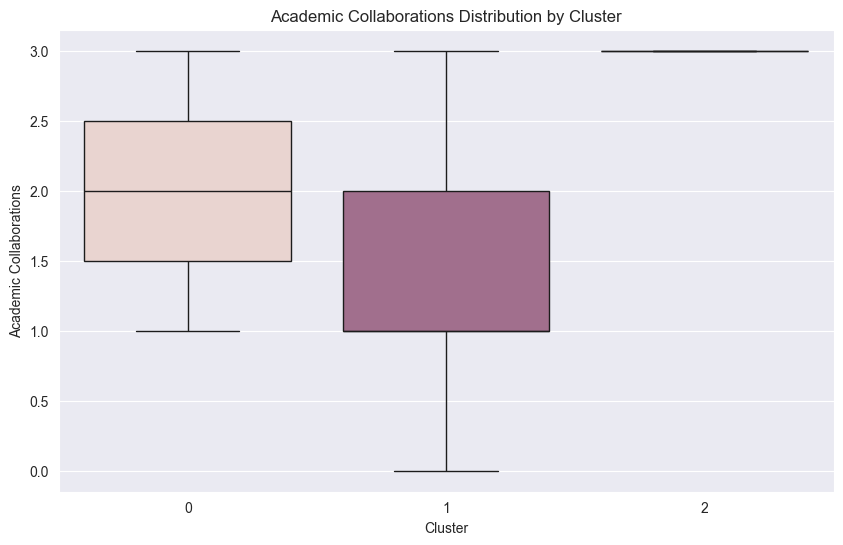

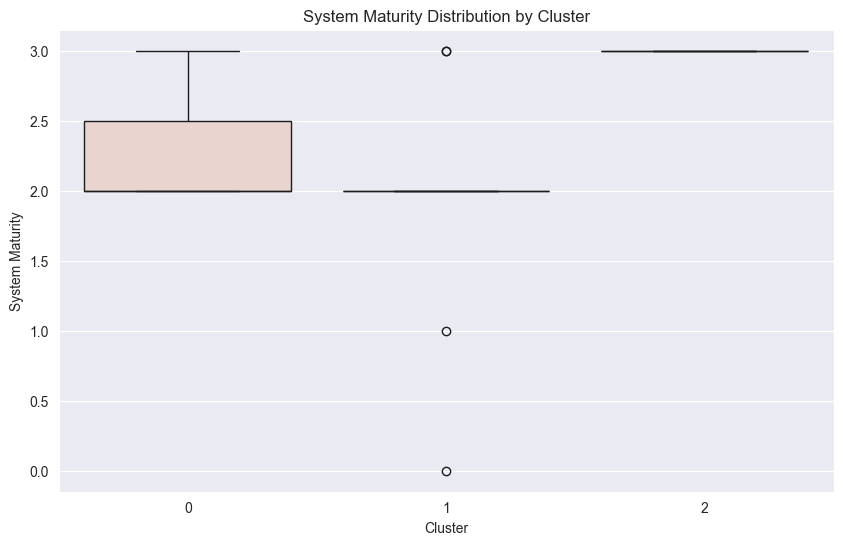

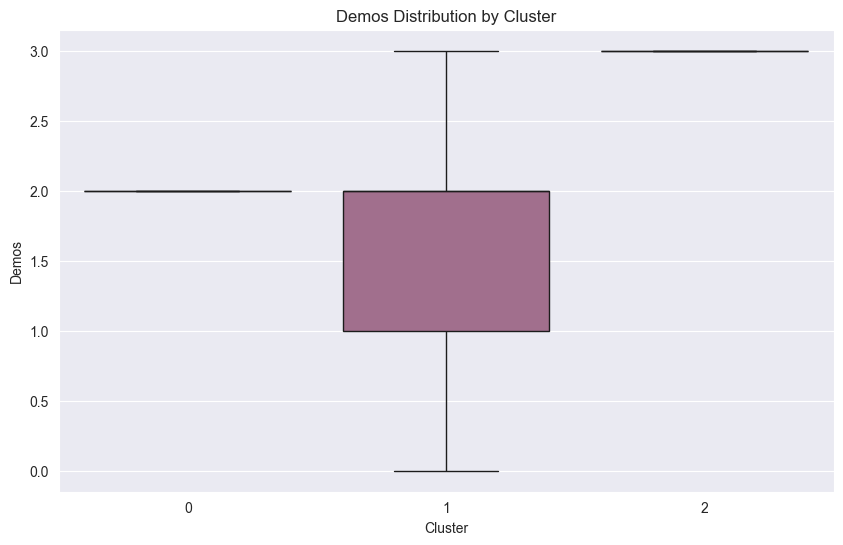

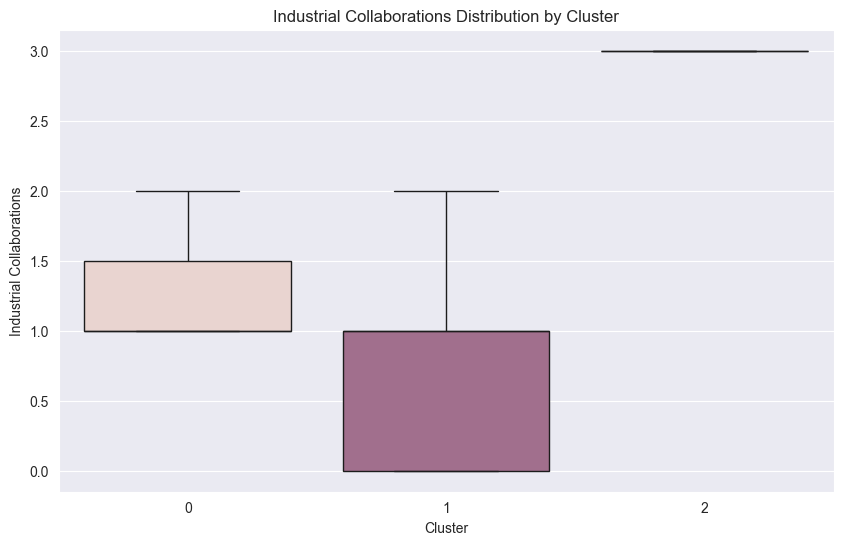

In [67]:
plot_cluster_box_plots(team_activity_df, features_c)

In [74]:
# Radar charts for cluster profiles
def plot_radar_chart(cluster_means, cluster_id):
    categories = list(cluster_means.columns)
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=7)
    plt.ylim(0,5)
    values = cluster_means.loc[cluster_id].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

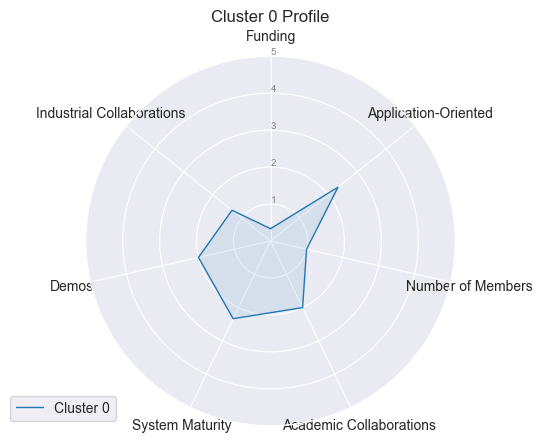

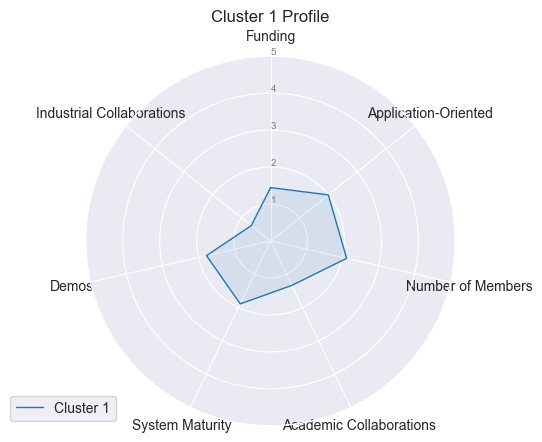

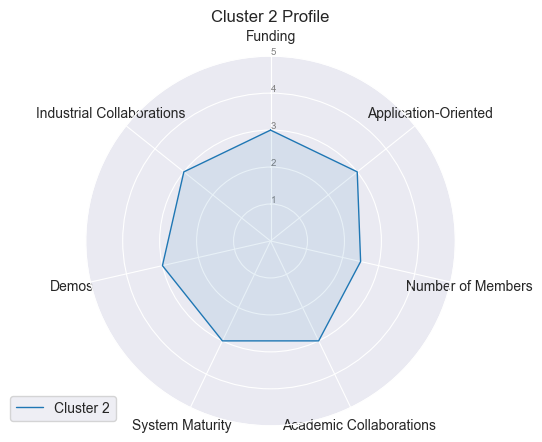

In [76]:
# Main execution for radar charts
cluster_means = team_activity_df.groupby('Cluster').mean(numeric_only=True)
cluster_means.drop('Performance Score', axis=1, inplace=True)
for cluster_id in cluster_means.index:
    plot_radar_chart(cluster_means, cluster_id)
    plt.title(f'Cluster {cluster_id} Profile')
    plt.show()